# Initialize the Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
#os.environ['MKL_NUM_THREADS'] = '1'
import sys
import glob
import json
import subprocess
from multiprocessing import Pool

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import scipy.sparse as sp
from sklearn import manifold
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams


import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

import scipy.stats as stats

os.chdir('../')
import Codebase
conv_adj_matr_to_cfg_matr = Codebase.Networks.configuration.convert_adj_matr_to_cfg_matr
conv_cfg_vec_to_adj_matr = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr
from Codebase.Networks.SubgraphDetection.nonnegfac import nmf
os.chdir('./Analysis_Notebooks/')

path_MetaData = '/home1/a/ankk/LittHome/Remotes/CORE.ieeg_ltm.multiinst/Raw_Neocortical'
path_CoreData = '/home1/a/ankk/LittHome/Remotes/CORE.ieeg_ltm.multiinst/Dyne_Neocortical/FuncConn.XCorr_WideBand.4_115/network'
path_PeriphData = '/home1/a/ankk/LittHome/Remotes/RSRCH.InterictalSubgraph'
path_InpData = path_PeriphData + '/ds-e03-NMF_Consensus'
path_ExpData = path_PeriphData + '/ds-e04-NMF_CoCluster'

for path in [path_CoreData, path_PeriphData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

/home1/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Generate Data List

In [2]:
# Get clinical_metadata
df_meta = h5py.File('{}/clinical_metadata.mat'.format(path_MetaData), 'r')
meta_subj = [''.join(unichr(c) for c in df_meta[r])
             for r in df_meta['subject']['ID'][:, 0]]

# Get the list of all NMF subgraph data
ev_list = glob.glob('{}/*.*.*.npz'.format(path_InpData))

subj_dict = {}
for path in ev_list:
    full_id = path.split('/')[-1].split('.npz')[0]
    subj_id = full_id.split('.')[0]
    epoch_id = full_id.split('.')[1]
    block_id = full_id.split('.')[2]
    
    try:
        subj_dict[subj_id]
    except KeyError:
        subj_dict[subj_id] = {'full_id': [],
                              'path': []}
        
    subj_dict[subj_id]['full_id'].append(full_id)
    subj_dict[subj_id]['path'].append(path)    

# NMF Subgraph Ensemble

## Generate Subgraph Ensemble Matrix

In [4]:
for subj_id in subj_dict.keys():
    n_block = len(subj_dict[subj_id]['full_id'])
    
    for ii, (full_id, path) in enumerate(zip(subj_dict[subj_id]['full_id'],
                                             subj_dict[subj_id]['path'])):
        
        nmf_consensus = np.load(path)
        fac_subnet = nmf_consensus['fac_subnet']
        fac_coef = nmf_consensus['fac_coef']        
        n_fac, n_conn = fac_subnet.shape        
        if ii == 0:
            subg_ensemble_matr = np.zeros((n_fac*n_block, n_conn))
            expr_ensemble_matr = []
            block_ensemble_matr = []

        for fac_ix in xrange(n_fac):
            subg_ensemble_matr[ii*n_fac + fac_ix, :] = fac_subnet[fac_ix, :]
            expr_ensemble_matr.append(fac_coef[fac_ix, :])
            block_ensemble_matr.append(full_id)
            
    expr_ensemble_matr = np.array(expr_ensemble_matr)         
    block_ensemble_matr = np.array(block_ensemble_matr) 
    
    np.savez('{}/NMF_Subgraph_Ensemble.{}.npz'.format(path_ExpData, subj_id),
             subg_ensemble_matr=subg_ensemble_matr,
             expr_ensemble_matr=expr_ensemble_matr,
             block_ensemble_matr=block_ensemble_matr)

## Run Ensemble NMF

In [3]:
alpha = 0.0
beta = 0.0
rank = [2, 20]
n_run = 100

# Generate parameter set
proc_item = []
for subj_id in subj_dict.keys():
    for rnk in xrange(rank[0], rank[1]+1):
        for run_i in xrange(n_run):
            run_id = run_i+1
            param = {'alpha': alpha,
                     'beta': beta,
                     'run_id': run_id, 
                     'rank': rnk}

            proc_dict = {'ensemble_path': '{}/NMF_Subgraph_Ensemble.{}.npz'.format(path_ExpData, subj_id),
                         'output_name': 'NMF_CoCluster.{}.{}.{}'.format(subj_id, rnk, run_id),
                         'param_set': param}
            proc_item.append(proc_dict)
        
np.savez('{}/NMF_CoCluster.Param_Search_Space.npz'.format(path_ExpData),
         proc_item=proc_item)

In [3]:
parallel_run = True

proc_item = np.load('{}/NMF_CoCluster.Param_Search_Space.npz'.format(path_ExpData))['proc_item']

# Remove already completed items from proc list
new_proc_item = []
for pitem in proc_item:
    if not os.path.exists("{}/{}.npz".format(path_ExpData, pitem['output_name'])):
        new_proc_item.append(pitem)
proc_item = new_proc_item

# Setup helper function to map NMF run
def _start_helper(pitem):
    print('Processing: {}'.format(pitem['output_name']))
        
    # Get Subgraph Ensemble Matrix
    subg_ensemble_matr = np.load(pitem['ensemble_path'])['subg_ensemble_matr']
    n_block = subg_ensemble_matr.shape[0]
    n_conn = subg_ensemble_matr.shape[1]


    block_group = np.random.permutation(n_block)
    group_size = 200

    W = np.random.uniform(low=0.0, high=1.0, size=(pitem['param_set']['rank'], n_conn))
    for blk_grp_ix in xrange(int(np.ceil(n_block / group_size))):
        ensemble_grp = subg_ensemble_matr[block_group[blk_grp_ix*group_size:(blk_grp_ix+1)*group_size], :]

        W, _, _ = nmf.snmf_bcd(
            ensemble_grp,                
            alpha=0.0,
            beta=0.0,
            fac_subnet_init=W,
            fac_coef_init=np.random.uniform(low=0.0, high=1.0,
                                            size=(pitem['param_set']['rank'],
                                                  ensemble_grp.shape[0])),
            max_iter=3, verbose=False)

    H, info = nmf.nnls.nnlsm_blockpivot(W.T, subg_ensemble_matr.T)
    
    A = subg_ensemble_matr
    A_hat = np.dot(W.T, H).T
    err = np.sum(np.abs(A-A_hat)**2)
    
    np.savez("{}/{}.npz".format(path_ExpData, pitem['output_name']),
             fac_ensemble_subg=W, fac_ensemble_coef=H, rank=pitem['param_set']['rank'],
             error=err)

if parallel_run:
    mp = Pool(40)
    mp.map(_start_helper, proc_item)
else:
    map(_start_helper, proc_item)

## Optimum Number of States

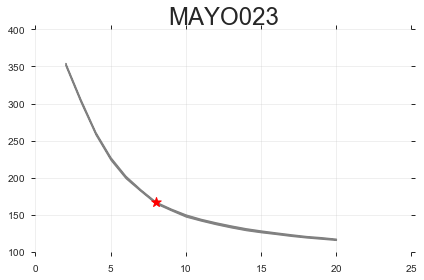

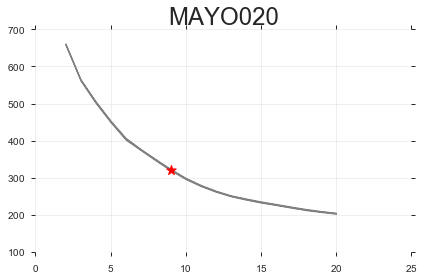

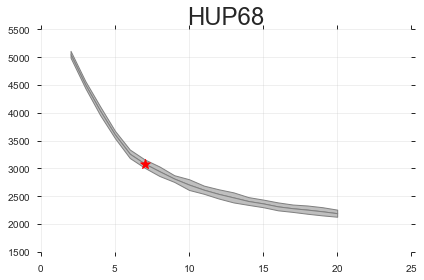

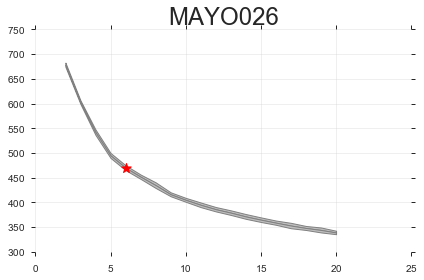

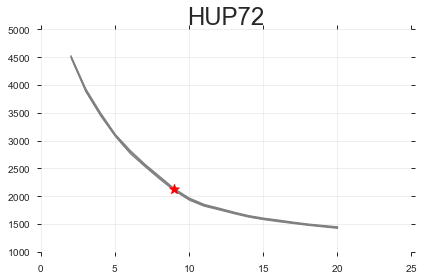

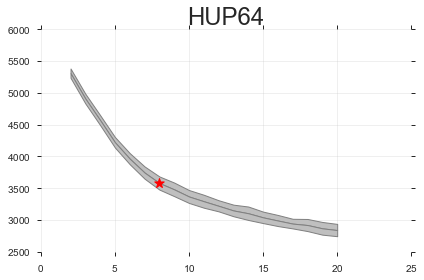

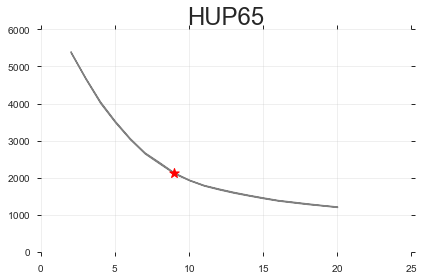

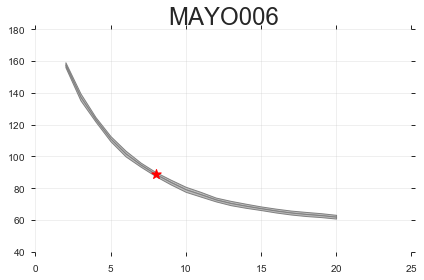

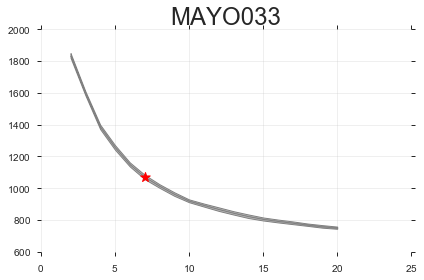

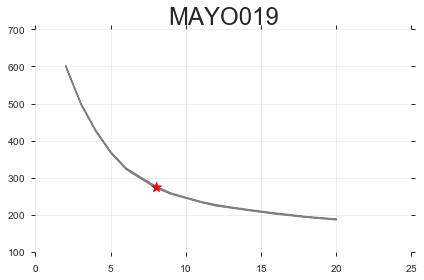

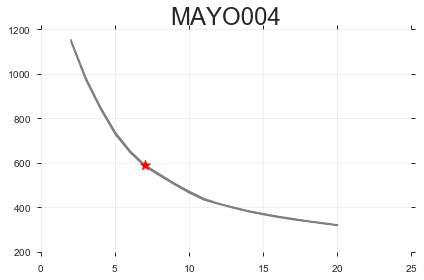

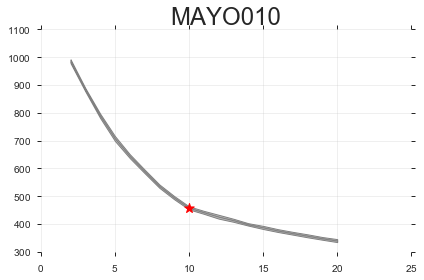

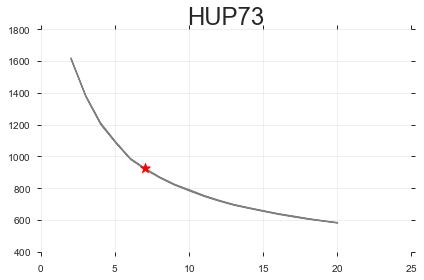

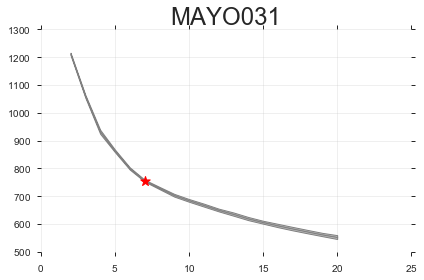

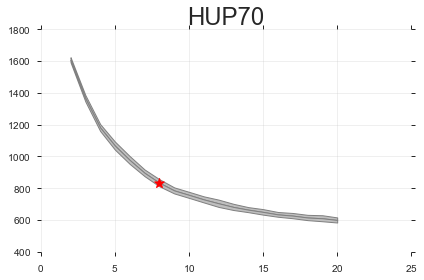

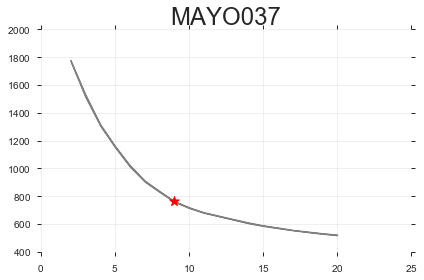

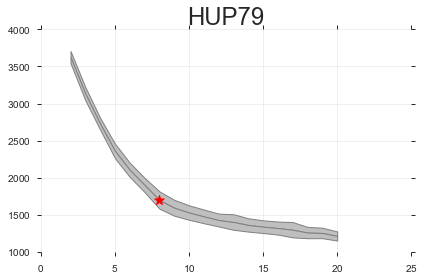

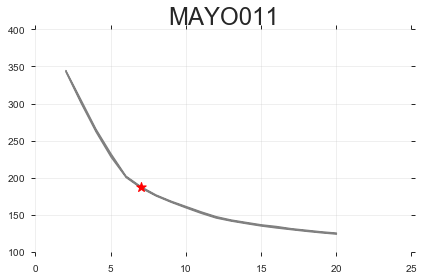

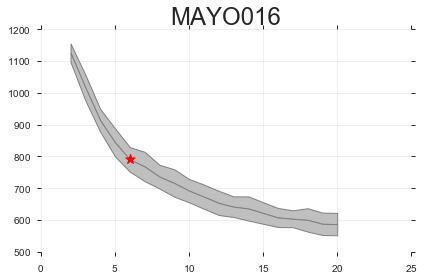

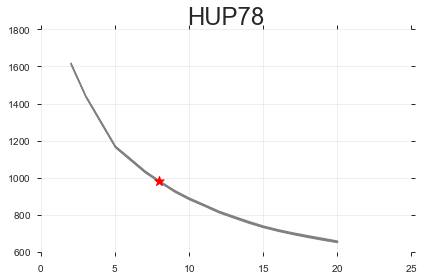

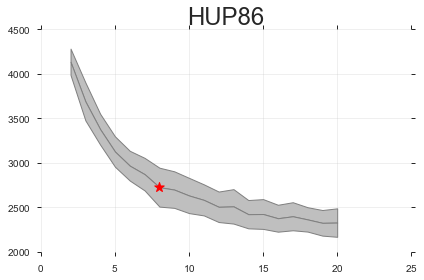

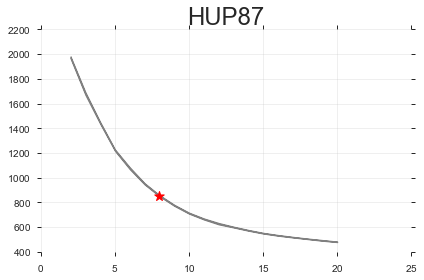

In [4]:
%matplotlib inline

for subj_id in subj_dict.keys():
    subj_paths = glob.glob('{}/NMF_CoCluster.{}.*.*.npz'.format(path_ExpData, subj_id))
    
    n_run = len(np.unique([int(p.split('/')[-1].split('.')[-2]) for p in subj_paths]))
    rank_list = np.unique([int(p.split('/')[-1].split('.')[-3]) for p in subj_paths])
    n_rank = len(rank_list)
    
    err_arr = np.zeros((n_run, n_rank))
    
    for ii, path in enumerate(subj_paths):
        run_ix = int(path.split('/')[-1].split('.')[-2])-1
        rank_ix = np.flatnonzero(rank_list == int(path.split('/')[-1].split('.')[-3]))[0]
        
        df = np.load(path)
        err_arr[run_ix, rank_ix] = df['error']
        df.close()

    err_mean = err_arr.mean(axis=0)
    err_stdev = err_arr.std(axis=0)    
        
    # Draw Plot
    plt.figure()
    ax = plt.subplot(111)
    ax.fill_between(rank_list, err_mean, err_mean+err_stdev)
    ax.fill_between(rank_list, err_mean, err_mean-err_stdev)    
    opt_ix = Codebase.Utilities.optimization.find_elbow(err_mean)
    ax.scatter(rank_list[opt_ix], err_mean[opt_ix], color='r', marker='*', s=100.0)
    ax.set_title(subj_id)
    plt.show()        

    np.savez('{}/{}.Num_Subgraph_State.npz'.format(path_ExpData, subj_id),
         n_subgraph=rank_list[opt_ix])    

# Subgraph Similarity

## Compute Similarity

In [ ]:
parallel_run = True

# Setup helper function to map NMF run
def _start_helper(subj_id):
    print('Processing: {}'.format(subj_id))

    file_txt = "{}/NMF_Subgraph_Similarity.{}.txt".format(path_ExpData, subj_id)
    file_out = "{}/NMF_Subgraph_Similarity.{}.npz".format(path_ExpData, subj_id)
    if os.path.exists(file_out):
        return 0
    
    opt_subg_rank = np.load('{}/{}.Num_Subgraph_State.npz'.format(path_ExpData, subj_id))['n_subgraph']
    
    subj_paths = glob.glob('{}/NMF_CoCluster.{}.{}.*.npz'.format(path_ExpData, subj_id,
                                                                 opt_subg_rank))
    n_run = len(subj_paths)
    
    for ii, path in enumerate(subj_paths):
        with open(file_txt, 'a') as myfile:
            myfile.write('Processing {} of {}'.format(ii+1, n_run))
            
        nmf_cocluster = np.load(path)
        H = nmf_cocluster['fac_ensemble_coef']        
        H_c = np.argmax(H, axis=0)
        n_block = H_c.shape[0]
        nmf_cocluster.close()
        
        if ii == 0:
            M = sp.csr_matrix((n_block, n_block), dtype=int)  
        
        for c_id in np.unique(H_c):
            c_ind = sp.csr_matrix((H_c == c_id).reshape(-1,1))
            c_out = c_ind.dot(c_ind.T)
            M += c_out
    
    M = M / float(n_run)
        
    np.savez(file_out,
             M_data=M.data,
             M_indices=M.indices,
             M_indptr=M.indptr,
             M_shape=M.shape)
    

if parallel_run:
    mp = Pool(30)
    mp.map(_start_helper, subj_dict.keys())
else:
    map(_start_helper, subj_dict.keys())

Processing: HUP64
Processing: MAYO004
Processing: MAYO023
Processing: MAYO019
Processing: MAYO006
Processing: MAYO026
Processing: MAYO020
Processing: MAYO033
Processing: MAYO010
Processing: MAYO031
Processing: HUP73
Processing: HUP70
Processing: HUP79
Processing: HUP72
Processing: HUP68
Processing: HUP65
Processing: MAYO037
Processing: HUP78
Processing: MAYO016
Processing: HUP86
Processing: MAYO011
Processing: HUP87


## Cluster Similarity into States

In [15]:
parallel_run = True

# Setup helper function to map NMF run
def _start_helper(subj_id):
    print('Processing: {}'.format(subj_id))

    file_out = "{}/NMF_Subgraph_States.{}.npz".format(path_ExpData, subj_id)
    #if os.path.exists(file_out):
    #    return 0

    subg_sim = np.load('{}/NMF_Subgraph_Similarity.{}.npz'.format(path_ExpData, subj_id))
    M = sp.csr_matrix((subg_sim['M_data'], subg_sim['M_indices'], subg_sim['M_indptr']),
                      shape=subg_sim['M_shape']).A
    opt_subg_rank = np.load('{}/{}.Num_Subgraph_State.npz'.format(path_ExpData, subj_id))['n_subgraph']

    # Compute NMF on Similarity matrix
    W, H, err = nmf.snmf_bcd(
        M,                
        alpha=0.0,
        beta=0.0,
        fac_subnet_init=np.random.uniform(low=0.0, high=1.0, size=(opt_subg_rank, M.shape[1])),
        fac_coef_init=np.random.uniform(low=0.0, high=1.0, size=(opt_subg_rank, M.shape[1])),
        max_iter=100, verbose=False)

    # Take W, and examine maximum coefficient
    clusters = np.argmax(W, axis=0)
      
    np.savez(file_out, states=clusters)    
    

if parallel_run:
    mp = Pool(10)
    mp.map(_start_helper, subj_dict.keys())
else:
    map(_start_helper, subj_dict.keys())

Processing: MAYO023
Processing: HUP72
Processing: MAYO033
Processing: MAYO020
Processing: MAYO026
Processing: HUP68
Processing: MAYO006
Processing: HUP64
Processing: HUP65
Processing: MAYO019
Processing: MAYO004
Processing: MAYO010
Processing: HUP73
Processing: MAYO031
Processing: HUP70
Processing: MAYO037
Processing: HUP79
Processing: MAYO011
Processing: MAYO016
Processing: HUP78
Processing: HUP86
Processing: HUP87


## Subgraph Projection (MDS)

In [3]:
for subj_id in subj_dict.keys():
    print('Processing: {}'.format(subj_id))
    
    file_out = "{}/NMF_Subgraph_Projection.{}.npz".format(path_ExpData, subj_id)
    if os.path.exists(file_out):
        continue

    df = np.load('{}/NMF_Subgraph_Similarity.{}.npz'.format(path_ExpData, subj_id))
    M = sp.csr_matrix((df['M_data'], df['M_indices'], df['M_indptr']), shape=df['M_shape']).A

    # Convert Consensus into dissimilarity
    # Shift 0 -> 1 to -1 -> 0; then invert 1 -> 0
    M -= 1
    M *= -1
    M[np.diag_indices_from(M)] = 0

    mds = manifold.MDS(n_components=2, dissimilarity='precomputed', n_jobs=30)
    M_mds = mds.fit_transform(M)
    
    np.savez(file_out, block_locs=M_mds) 

Processing: MAYO023
Processing: MAYO020
Processing: HUP68
Processing: MAYO026
Processing: HUP72
Processing: HUP64
Processing: HUP65
Processing: MAYO006
Processing: MAYO033
Processing: MAYO019
Processing: MAYO004
Processing: MAYO010
Processing: HUP73
Processing: MAYO031
Processing: HUP70
Processing: MAYO037
Processing: HUP79
Processing: MAYO011
Processing: MAYO016
Processing: HUP78
Processing: HUP86
Processing: HUP87


## Plot Subgraph Projection

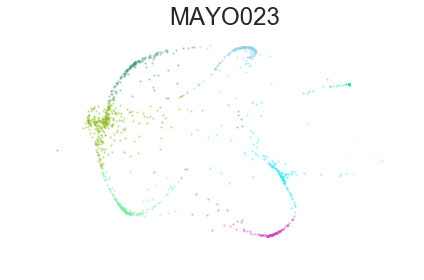

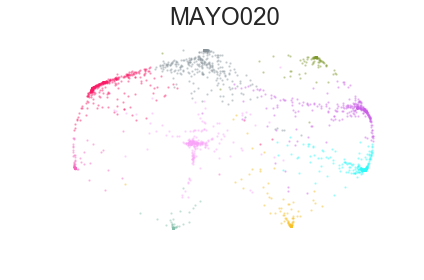

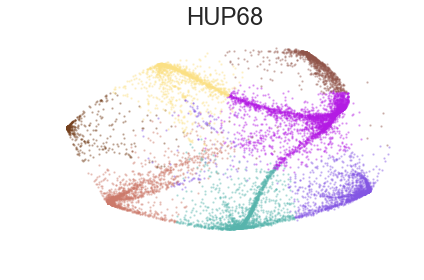

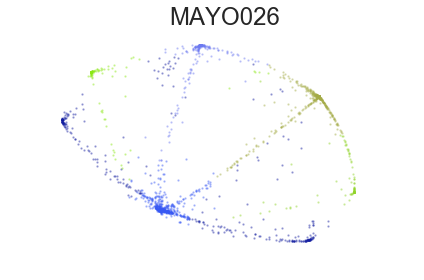

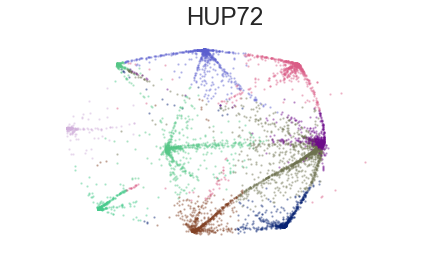

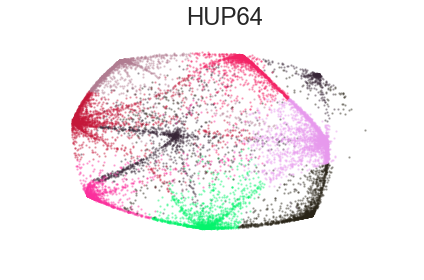

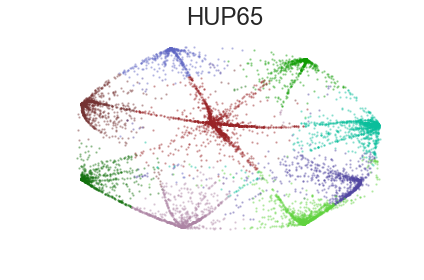

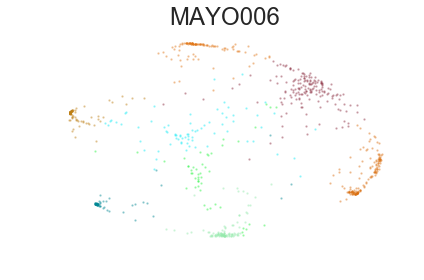

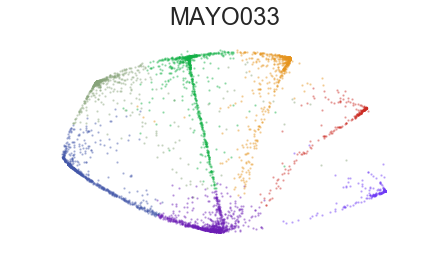

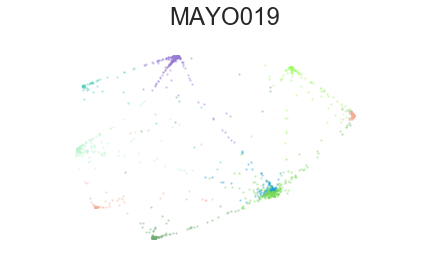

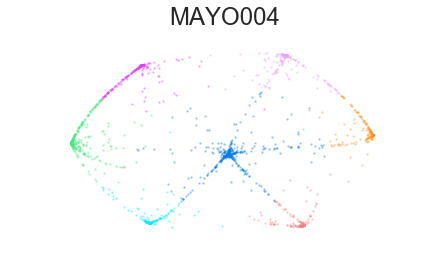

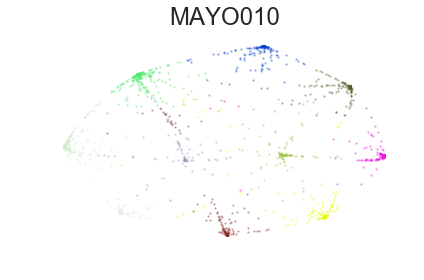

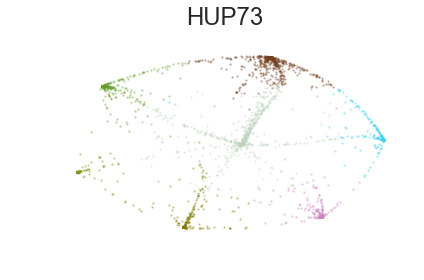

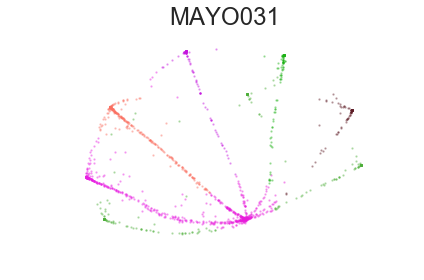

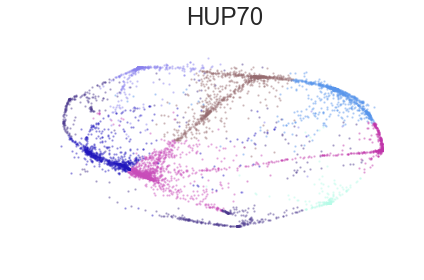

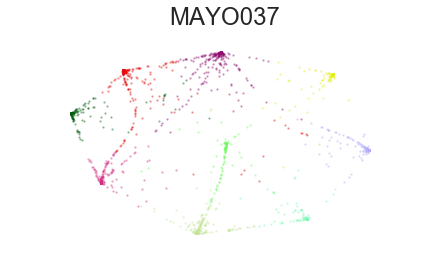

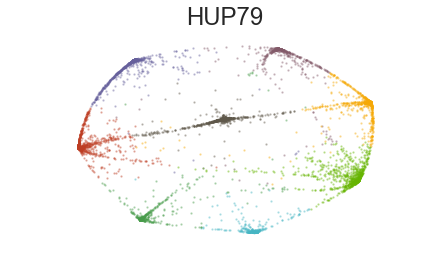

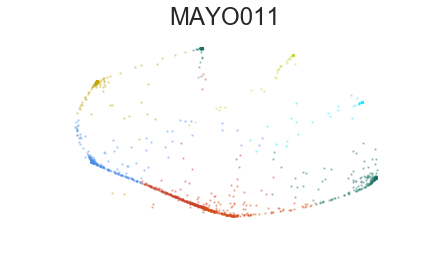

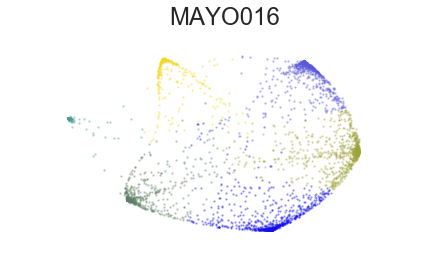

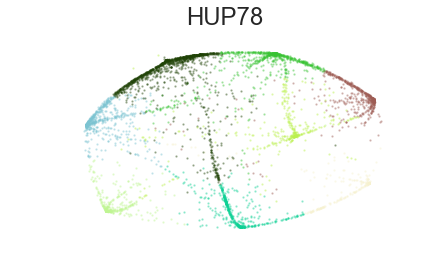

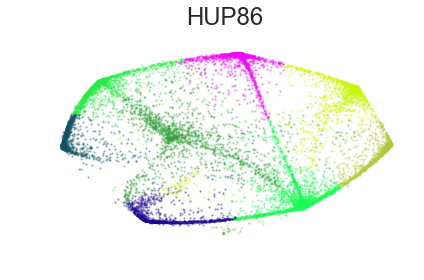

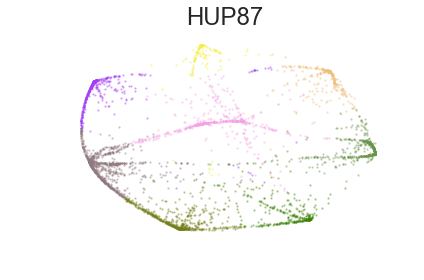

In [26]:
for subj_id in subj_dict.keys():
    block_locs = np.load('{}/NMF_Subgraph_Projection.{}.npz'.format(path_ExpData, subj_id))['block_locs']
    states = np.load('{}/NMF_Subgraph_States.{}.npz'.format(path_ExpData, subj_id))['states']
    state_id = np.unique(states)
    n_state = len(np.unique(states))

    %matplotlib inline
    plt.figure()
    ax = plt.subplot(111)
    clr = np.random.uniform(low=0.0, high=1.0, size=(n_state, 3))
    for st_id in state_id:
        st_ix = np.flatnonzero(states == st_id)
        ax.scatter(block_locs[st_ix,0], block_locs[st_ix,1],
                   color=clr[st_id, :], s=2.0, alpha=0.3)
    ax.set_axis_off()
    ax.set_title(subj_id)
    plt.show()

# NMF Subgraph Ensemble (Null)

## Generate Subgraph Ensemble Matrix (Null)

In [34]:
for subj_id in subj_dict.keys():
    print('Processing: {}'.format(subj_id))
    
    n_block = len(subj_dict[subj_id]['full_id'])
    
    for ii, (full_id, path) in enumerate(zip(subj_dict[subj_id]['full_id'],
                                             subj_dict[subj_id]['path'])):
        
        nmf_consensus = np.load(path)
        fac_subnet = nmf_consensus['fac_subnet']
        n_fac, n_conn = fac_subnet.shape    
        
        # Generate null basis
        rand_w = np.random.random(size=(n_fac, n_fac))
        norm_w = rand_w / np.linalg.norm(rand_w)
        fac_subnet = np.dot(norm_w, fac_subnet)
        
        if ii == 0:
            subg_ensemble_matr = np.zeros((n_fac*n_block, n_conn))
            block_ensemble_matr = []

        for fac_ix in xrange(n_fac):
            subg_ensemble_matr[ii*n_fac + fac_ix, :] = fac_subnet[fac_ix, :]
            block_ensemble_matr.append(full_id)
        
    block_ensemble_matr = np.array(block_ensemble_matr) 
    
    np.savez('{}/NMF_Subgraph_Ensemble.NULL.{}.npz'.format(path_ExpData, subj_id),
             subg_ensemble_matr=subg_ensemble_matr,
             block_ensemble_matr=block_ensemble_matr)

Processing: MAYO023
Processing: MAYO020
Processing: HUP68
Processing: MAYO026
Processing: HUP72
Processing: HUP64
Processing: HUP65
Processing: MAYO006
Processing: MAYO033
Processing: MAYO019
Processing: MAYO004
Processing: MAYO010
Processing: HUP73
Processing: MAYO031
Processing: HUP70
Processing: MAYO037
Processing: HUP79
Processing: MAYO011
Processing: MAYO016
Processing: HUP78
Processing: HUP86
Processing: HUP87


## Run Ensemble NMF (Null)

In [41]:
alpha = 0.0
beta = 0.0
n_run = 100

# Generate parameter set
proc_item = []
for subj_id in subj_dict.keys():
    
    rank = int(np.load('{}/{}.Num_Subgraph_State.npz'.format(path_ExpData, subj_id))['n_subgraph'])
    for run_i in xrange(n_run):
        run_id = run_i+1
        param = {'alpha': alpha,
                 'beta': beta,
                 'run_id': run_id, 
                 'rank': rank}

        proc_dict = {'ensemble_path': '{}/NMF_Subgraph_Ensemble.NULL.{}.npz'.format(path_ExpData, subj_id),
                     'output_name': 'NMF_CoCluster.NULL.{}.{}.{}'.format(subj_id, rank, run_id),
                     'param_set': param}
        proc_item.append(proc_dict)
        
np.savez('{}/NMF_CoCluster.NULL.Param_Search_Space.npz'.format(path_ExpData),
         proc_item=proc_item)

In [ ]:
parallel_run = True

proc_item = np.load('{}/NMF_CoCluster.NULL.Param_Search_Space.npz'.format(path_ExpData))['proc_item']

# Remove already completed items from proc list
new_proc_item = []
for pitem in proc_item:
    if not os.path.exists("{}/{}.npz".format(path_ExpData, pitem['output_name'])):
        new_proc_item.append(pitem)
proc_item = new_proc_item

# Setup helper function to map NMF run
def _start_helper(pitem):
    print('Processing: {}'.format(pitem['output_name']))
        
    # Get Subgraph Ensemble Matrix
    subg_ensemble_matr = np.load(pitem['ensemble_path'])['subg_ensemble_matr']
    n_block = subg_ensemble_matr.shape[0]
    n_conn = subg_ensemble_matr.shape[1]


    block_group = np.random.permutation(n_block)
    group_size = 200

    W = np.random.uniform(low=0.0, high=1.0, size=(pitem['param_set']['rank'], n_conn))
    for blk_grp_ix in xrange(int(np.ceil(n_block / group_size))):
        ensemble_grp = subg_ensemble_matr[block_group[blk_grp_ix*group_size:(blk_grp_ix+1)*group_size], :]

        W, _, _ = nmf.snmf_bcd(
            ensemble_grp,                
            alpha=0.0,
            beta=0.0,
            fac_subnet_init=W,
            fac_coef_init=np.random.uniform(low=0.0, high=1.0,
                                            size=(pitem['param_set']['rank'],
                                                  ensemble_grp.shape[0])),
            max_iter=3, verbose=False)

    H, info = nmf.nnls.nnlsm_blockpivot(W.T, subg_ensemble_matr.T)
    
    A = subg_ensemble_matr
    A_hat = np.dot(W.T, H).T
    err = np.sum(np.abs(A-A_hat)**2)
    
    np.savez("{}/{}.npz".format(path_ExpData, pitem['output_name']),
             fac_ensemble_subg=W, fac_ensemble_coef=H, rank=pitem['param_set']['rank'],
             error=err)

if parallel_run:
    mp = Pool(40)
    mp.map(_start_helper, proc_item)
else:
    map(_start_helper, proc_item)

Processing: NMF_CoCluster.NULL.MAYO023.8.1
Processing: NMF_CoCluster.NULL.MAYO023.8.15
Processing: NMF_CoCluster.NULL.MAYO023.8.57
Processing: NMF_CoCluster.NULL.MAYO023.8.29
Processing: NMF_CoCluster.NULL.MAYO023.8.43
Processing: NMF_CoCluster.NULL.MAYO023.8.71
Processing: NMF_CoCluster.NULL.MAYO023.8.85
Processing: NMF_CoCluster.NULL.MAYO023.8.99
Processing: NMF_CoCluster.NULL.MAYO020.9.27
Processing: NMF_CoCluster.NULL.MAYO020.9.13
Processing: NMF_CoCluster.NULL.MAYO020.9.55
Processing: NMF_CoCluster.NULL.MAYO020.9.41
Processing: NMF_CoCluster.NULL.MAYO020.9.69
Processing: NMF_CoCluster.NULL.MAYO020.9.83
Processing: NMF_CoCluster.NULL.MAYO020.9.97
Processing: NMF_CoCluster.NULL.HUP68.7.25
Processing: NMF_CoCluster.NULL.HUP68.7.53
Processing: NMF_CoCluster.NULL.HUP68.7.39
Processing: NMF_CoCluster.NULL.HUP68.7.11
Processing: NMF_CoCluster.NULL.HUP68.7.67
Processing: NMF_CoCluster.NULL.HUP68.7.81
Processing: NMF_CoCluster.NULL.MAYO026.6.65
Processing: NMF_CoCluster.NULL.HUP68.7.95
Pro

Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:5

Processing: NMF_CoCluster.NULL.MAYO023.8.86


Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Processing: NMF_CoCluster.NULL.MAYO023.8.58


Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Processing: NMF_CoCluster.NULL.MAYO023.8.30
Processing: NMF_CoCluster.NULL.MAYO023.8.72


Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Processing: NMF_CoCluster.NULL.MAYO023.8.16


Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Processing: NMF_CoCluster.NULL.MAYO023.8.100


Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Processing: NMF_CoCluster.NULL.MAYO023.8.2
Processing: NMF_CoCluster.NULL.MAYO023.8.44


Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Processing: NMF_CoCluster.NULL.MAYO020.9.28
Processing: NMF_CoCluster.NULL.MAYO020.9.98
Processing: NMF_CoCluster.NULL.MAYO020.9.84
Processing: NMF_CoCluster.NULL.MAYO020.9.42
Processing: NMF_CoCluster.NULL.MAYO020.9.14
Processing: NMF_CoCluster.NULL.MAYO020.9.70
Processing: NMF_CoCluster.NULL.MAYO020.9.56
Processing: NMF_CoCluster.NULL.MAYO026.6.52
Processing: NMF_CoCluster.NULL.MAYO026.6.10
Processing: NMF_CoCluster.NULL.MAYO026.6.66
Processing: NMF_CoCluster.NULL.MAYO026.6.24
Processing: NMF_CoCluster.NULL.MAYO026.6.94
Processing: NMF_CoCluster.NULL.MAYO026.6.80
Processing: NMF_CoCluster.NULL.MAYO026.6.38
Processing: NMF_CoCluster.NULL.MAYO023.8.87
Processing: NMF_CoCluster.NULL.MAYO023.8.31
Processing: NMF_CoCluster.NULL.MAYO023.8.59
Processing: NMF_CoCluster.NULL.MAYO023.8.17
Processing: NMF_CoCluster.NULL.MAYO023.8.3
Processing: NMF_CoCluster.NULL.MAYO020.9.43
Processing: NMF_CoCluster.NULL.MAYO020.9.1
Processing: NMF_CoCluster.NULL.MAYO023.8.45
Processing: NMF_CoCluster.NULL.MAY

# Subgraph Similarity (Null)

## Compute Similarity (Null)

In [4]:
parallel_run = True

# Setup helper function to map NMF run
def _start_helper(subj_id):
    print('Processing: {}'.format(subj_id))

    file_txt = "{}/NMF_Subgraph_Similarity.NULL.{}.txt".format(path_ExpData, subj_id)
    file_out = "{}/NMF_Subgraph_Similarity.NULL.{}.npz".format(path_ExpData, subj_id)
    if os.path.exists(file_out):
        return 0
    
    opt_subg_rank = np.load('{}/{}.Num_Subgraph_State.npz'.format(path_ExpData, subj_id))['n_subgraph']
    
    subj_paths = glob.glob('{}/NMF_CoCluster.NULL.{}.{}.*.npz'.format(path_ExpData, subj_id,
                                                                 opt_subg_rank))
    n_run = len(subj_paths)
    
    for ii, path in enumerate(subj_paths):
        with open(file_txt, 'a') as myfile:
            myfile.write('Processing {} of {}'.format(ii+1, n_run))
            
        nmf_cocluster = np.load(path)
        H = nmf_cocluster['fac_ensemble_coef']        
        H_c = np.argmax(H, axis=0)
        n_block = H_c.shape[0]
        nmf_cocluster.close()
        
        if ii == 0:
            M = sp.csr_matrix((n_block, n_block), dtype=int)  
        
        for c_id in np.unique(H_c):
            c_ind = sp.csr_matrix((H_c == c_id).reshape(-1,1))
            c_out = c_ind.dot(c_ind.T)
            M += c_out
    
    M = M / float(n_run)
        
    np.savez(file_out,
             M_data=M.data,
             M_indices=M.indices,
             M_indptr=M.indptr,
             M_shape=M.shape)
    

if parallel_run:
    mp = Pool(30)
    mp.map(_start_helper, subj_dict.keys())
else:
    map(_start_helper, subj_dict.keys())

Processing: MAYO023
Processing: HUP68
Processing: MAYO020
Processing: MAYO006
Processing: HUP64
Processing: HUP65
Processing: MAYO026
Processing: HUP70
Processing: HUP87
Processing: MAYO016
Processing: MAYO004
Processing: HUP73
Processing: HUP79
Processing: HUP78
Processing: HUP86
Processing: MAYO011
Processing: MAYO010
Processing: MAYO037
Processing: MAYO031
Processing: MAYO033
Processing: HUP72
Processing: MAYO019


## Cluster Similarity into States (Null)

In [5]:
parallel_run = True

# Setup helper function to map NMF run
def _start_helper(subj_id):
    print('Processing: {}'.format(subj_id))

    file_out = "{}/NMF_Subgraph_States.NULL.{}.npz".format(path_ExpData, subj_id)
    #if os.path.exists(file_out):
    #    return 0

    subg_sim = np.load('{}/NMF_Subgraph_Similarity.NULL.{}.npz'.format(path_ExpData, subj_id))
    M = sp.csr_matrix((subg_sim['M_data'], subg_sim['M_indices'], subg_sim['M_indptr']),
                      shape=subg_sim['M_shape']).A
    opt_subg_rank = np.load('{}/{}.Num_Subgraph_State.npz'.format(path_ExpData, subj_id))['n_subgraph']

    # Compute NMF on Similarity matrix
    W, H, err = nmf.snmf_bcd(
        M,                
        alpha=0.0,
        beta=0.0,
        fac_subnet_init=np.random.uniform(low=0.0, high=1.0, size=(opt_subg_rank, M.shape[1])),
        fac_coef_init=np.random.uniform(low=0.0, high=1.0, size=(opt_subg_rank, M.shape[1])),
        max_iter=100, verbose=False)

    # Take W, and examine maximum coefficient
    clusters = np.argmax(W, axis=0)
      
    np.savez(file_out, states=clusters)    
    

if parallel_run:
    mp = Pool(10)
    mp.map(_start_helper, subj_dict.keys())
else:
    map(_start_helper, subj_dict.keys())

Processing: MAYO020
Processing: MAYO006
Processing: HUP64
Processing: MAYO019
Processing: HUP68
Processing: HUP72
Processing: MAYO023
Processing: MAYO026
Processing: HUP65
Processing: MAYO033


Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:5

Processing: MAYO004


Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Processing: MAYO010


Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Processing: HUP73
Processing: MAYO031
Processing: HUP70
Processing: MAYO037


Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Processing: HUP79
Processing: MAYO011
Processing: MAYO016
Processing: HUP78
Processing: HUP86
Processing: HUP87


## Subgraph Projection (MDS) (Null)

In [ ]:
for subj_id in subj_dict.keys():
    print('Processing: {}'.format(subj_id))
    
    file_out = "{}/NMF_Subgraph_Projection.NULL.{}.npz".format(path_ExpData, subj_id)
    if os.path.exists(file_out):
        continue

    df = np.load('{}/NMF_Subgraph_Similarity.NULL.{}.npz'.format(path_ExpData, subj_id))
    M = sp.csr_matrix((df['M_data'], df['M_indices'], df['M_indptr']), shape=df['M_shape']).A

    # Convert Consensus into dissimilarity
    # Shift 0 -> 1 to -1 -> 0; then invert 1 -> 0
    M -= 1
    M *= -1
    M[np.diag_indices_from(M)] = 0

    mds = manifold.MDS(n_components=2, dissimilarity='precomputed', n_jobs=30)
    M_mds = mds.fit_transform(M)
    
    np.savez(file_out, block_locs=M_mds) 

Processing: MAYO023
Processing: MAYO020
Processing: HUP68
Processing: MAYO026
Processing: HUP72
Processing: HUP64
Processing: HUP65
Processing: HUP87


## Plot Subgraph Projection (Null)

/home1/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


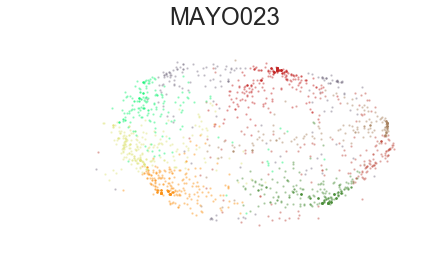

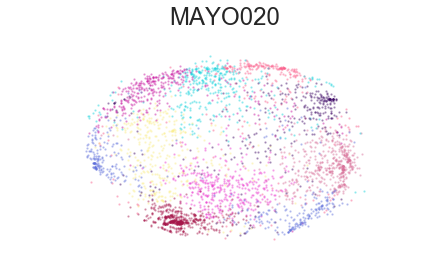

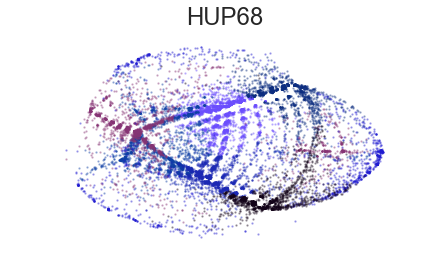

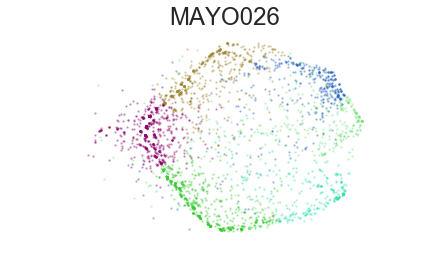

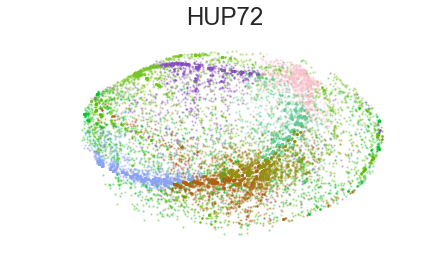

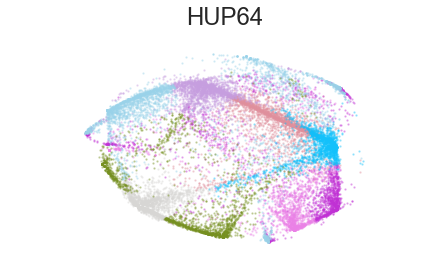

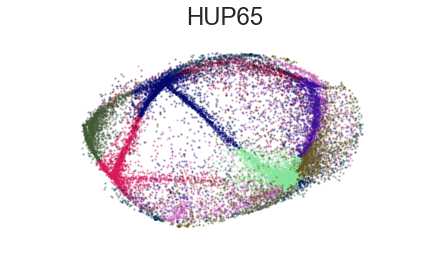

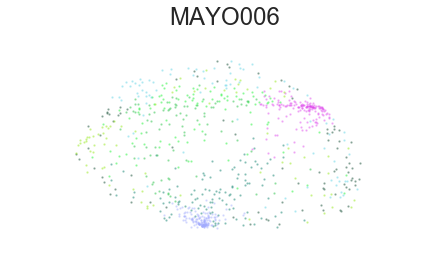

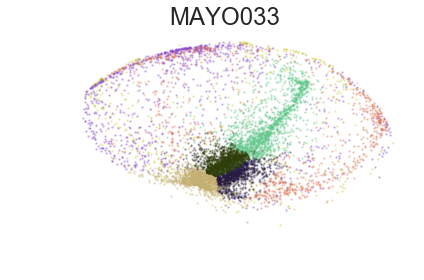

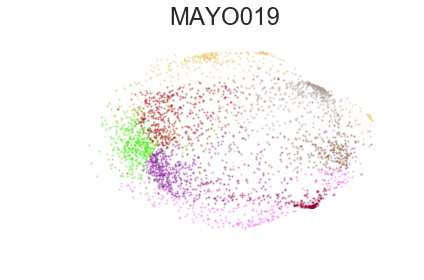

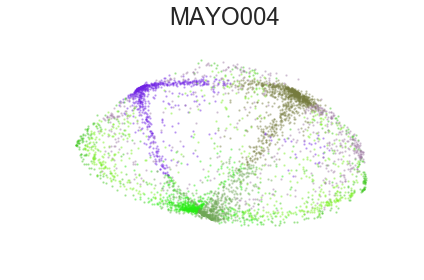

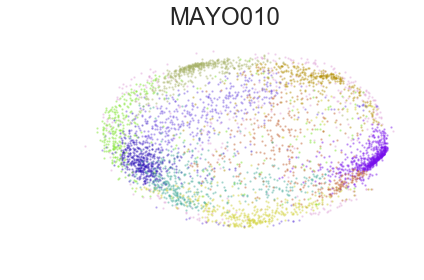

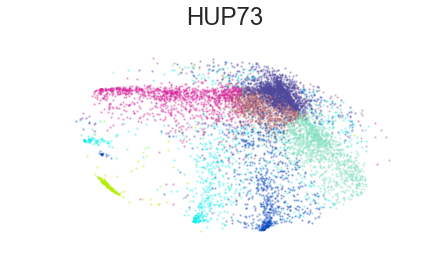

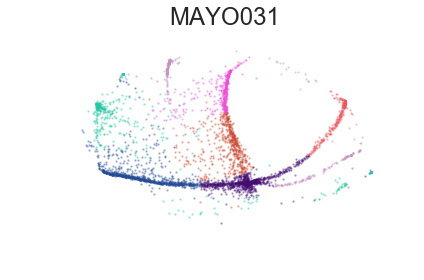

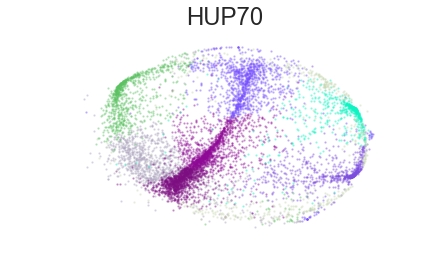

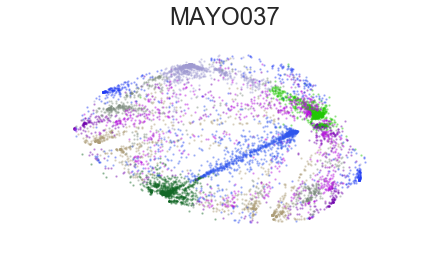

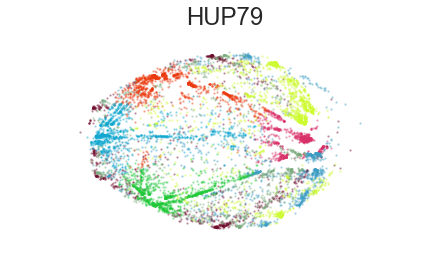

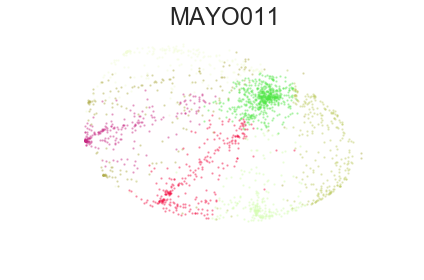

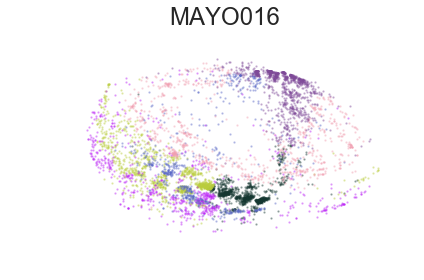

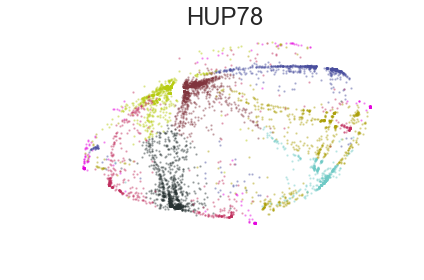

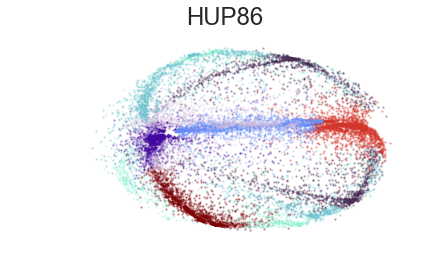

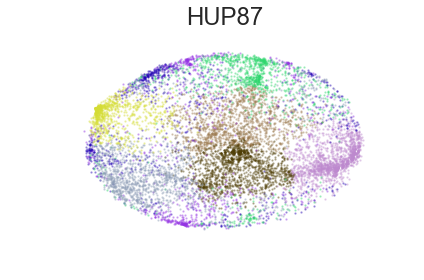

In [4]:
for subj_id in subj_dict.keys():
    block_locs = np.load('{}/NMF_Subgraph_Projection.NULL.{}.npz'.format(path_ExpData, subj_id))['block_locs']
    states = np.load('{}/NMF_Subgraph_States.NULL.{}.npz'.format(path_ExpData, subj_id))['states']
    state_id = np.unique(states)
    n_state = len(np.unique(states))

    %matplotlib inline
    plt.figure()
    ax = plt.subplot(111)
    clr = np.random.uniform(low=0.0, high=1.0, size=(n_state, 3))
    for st_id in state_id:
        st_ix = np.flatnonzero(states == st_id)
        ax.scatter(block_locs[st_ix,0], block_locs[st_ix,1],
                   color=clr[st_id, :], s=2.0, alpha=0.3)
    ax.set_axis_off()
    ax.set_title(subj_id)
    plt.show()